# Week 7–8: Fine-tune DistilBERT + Visualizations (Local PC)
**Labels:** 0 = low, 1 = neutral, 2 = high

Artifacts saved to `week7-8_distilbert/`:
- `model/` (Hugging Face model dir)
- `metrics.json`
- `confusion_matrix.png`
- `predictions.csv`
- `token_importance_samples.csv` (simple attention-based token scores)


## Setup (run these in your VS Code terminal)
```powershell
pip install -r requirements_week7-8.txt


In [1]:

# --- Imports & Paths (PyTorch-only, sanity-checked) ---

from pathlib import Path
import os, sys, json, random, inspect

# Force Transformers to use PyTorch only (no TF/Flax), and silence tokenizer warnings
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Core libs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# Torch / Datasets / Transformers
import torch
from datasets import Dataset
import transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Paths ---
DATA_PATH = Path("../week1-2_dataset/confidence_journal_week1-2.csv")
OUT_DIR   = Path("week7-8_distilbert")   # keep all week 7–8 artifacts here
OUT_DIR.mkdir(parents=True, exist_ok=True)

assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}"

# --- Environment / version diagnostics ---
print("Python        :", sys.version)
print("Torch         :", torch.__version__)
print("Transformers  :", transformers.__version__)
print("Data          :", DATA_PATH.resolve())
print("Out           :", OUT_DIR.resolve())

# Show the exact source files used (helps catch wrong imports)
print("Transformers __init__ file     :", inspect.getfile(transformers))
print("TrainingArguments source file  :", inspect.getfile(TrainingArguments))



c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python        : 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
Torch         : 2.9.0+cpu
Transformers  : 4.57.2
Data          : C:\Users\earne\Downloads\neural-confidence-journal\week1-2_dataset\confidence_journal_week1-2.csv
Out           : C:\Users\earne\Downloads\neural-confidence-journal\week7-8_distilbert\week7-8_distilbert
Transformers __init__ file     : c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\transformers\__init__.py
TrainingArguments source file  : c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\transformers\training_args.py


In [2]:
df = pd.read_csv(DATA_PATH)
needed = {'text','label'}
assert needed.issubset(df.columns), f"CSV must contain {needed}, found {df.columns.tolist()}"

# Ensure integer class labels 0/1/2
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)

print(df['label'].value_counts().sort_index())
df.head()

label
0    16
1    18
2    16
Name: count, dtype: int64


,text,label
0,I kept rewriting the email because I was worri...,0
1,I froze during the stand‑up and stumbled over ...,0
2,I’m second‑guessing the whole plan; maybe I to...,0
3,I felt small in that conversation and didn’t s...,0
4,I looked at the to‑do list and felt like I’ll ...,0


In [3]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)
print('Train size:', len(train_df), 'Val size:', len(val_df))

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

Train size: 40 Val size: 10


In [4]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding=False, max_length=128)

train_tokenized = train_ds.map(tokenize_fn, batched=True)
val_tokenized   = val_ds.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 10/10 [00:00<00:00, 1097.64 examples/s]


In [5]:
num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cpu')

In [6]:
id2label = {0:'low', 1:'neutral', 2:'high'}
label2id = {'low':0,'neutral':1,'high':2}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision_macro': prec, 'recall_macro': rec, 'f1_macro': f1}

In [ ]:
import inspect
from transformers import TrainingArguments, Trainer

# Common kwargs
ta_kwargs = dict(
    output_dir=str(OUT_DIR / "model"),
    num_train_epochs=6,                 # small dataset ⇒ a few more epochs
    per_device_train_batch_size=4,      # CPU-friendly
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,      # emulate larger batch
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=10,
    seed=SEED,
    report_to=[],
)

# Pick the right kw name for your installed TrainingArguments
sig = inspect.signature(TrainingArguments.__init__)
if "evaluation_strategy" in sig.parameters:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig.parameters:
    ta_kwargs["eval_strategy"] = "epoch"
else:
    # Fall back: no automatic eval each epoch; we'll just call evaluate() after training
    print("Warning: no eval_strategy/evaluation_strategy in TrainingArguments; "
          "we will run a separate evaluate() after training.")

training_args = TrainingArguments(**ta_kwargs)

# If the notebooks defined these as train_tokenized/val_tokenized, keep them:
try:
    _ = train_dataset
except NameError:
    train_dataset = train_tokenized
    val_dataset   = val_tokenized

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
eval_metrics = trainer.evaluate()  # still safe if eval ran each epoch
print(eval_metrics)

with open(OUT_DIR / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(eval_metrics, f, indent=2)


C:\Users\earne\AppData\Local\Temp\ipykernel_4660\1218532464.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,No log,1.078815,0.300000,0.250000,0.305556,0.232323
2,No log,1.058221,0.600000,0.716667,0.583333,0.583333
3,No log,1.039381,0.700000,0.722222,0.666667,0.666667
4,1.056500,1.024591,0.700000,0.722222,0.666667,0.666667
5,1.056500,1.014424,0.700000,0.722222,0.666667,0.666667
6,1.056500,1.010158,0.700000,0.722222,0.666667,0.666667


c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  

{'eval_loss': 1.0393812656402588, 'eval_accuracy': 0.7, 'eval_precision_macro': 0.7222222222222222, 'eval_recall_macro': 0.6666666666666666, 'eval_f1_macro': 0.6666666666666666, 'eval_runtime': 0.3685, 'eval_samples_per_second': 27.139, 'eval_steps_per_second': 8.142, 'epoch': 6.0}


In [ ]:
from pathlib import Path
import json

ART_DIR = OUT_DIR / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save model + tokenizer (HF format)
model.save_pretrained(ART_DIR)
tokenizer.save_pretrained(ART_DIR)

# Save metrics 
with open(ART_DIR / "eval_metrics.json", "w", encoding="utf-8") as f:
    json.dump(eval_metrics, f, indent=2)
print("Saved to:", ART_DIR)

Saved to: week7-8_distilbert\artifacts


c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

         Low      1.000     0.667     0.800         3
     Neutral      0.667     1.000     0.800         4
        High      0.500     0.333     0.400         3

    accuracy                          0.700        10
   macro avg      0.722     0.667     0.667        10
weighted avg      0.717     0.700     0.680        10

Saved figure: week7-8_distilbert\confusion_matrix_distilbert.png
Saved predictions: week7-8_distilbert\val_predictions_distilbert.csv


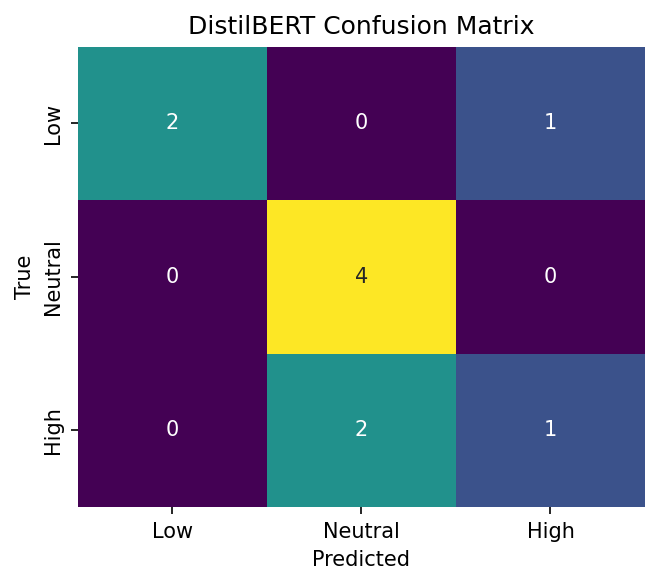

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the *validation* split
preds = trainer.predict(val_tokenized)
probs = torch.softmax(torch.tensor(preds.predictions), dim=-1).numpy()
y_true = preds.label_ids
y_pred = probs.argmax(axis=1)

# Map ids → label names for readability
id2lab = {0:"Low",1:"Neutral",2:"High"}
lab2id = {v:k for k,v in id2lab.items()}

# Pretty classification report
print(classification_report(y_true, y_pred, target_names=[id2lab[i] for i in range(3)], digits=3))

# Confusion matrix figure
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(4.5,4.0), dpi=150)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False, ax=ax,
            xticklabels=[id2lab[i] for i in range(3)],
            yticklabels=[id2lab[i] for i in range(3)])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("DistilBERT Confusion Matrix")
fig.tight_layout()
fig_path = OUT_DIR / "confusion_matrix_distilbert.png"
fig.savefig(fig_path)
print("Saved figure:", fig_path)

# Save a tidy predictions table
val_texts = val_df["text"].to_list()
pred_tbl = pd.DataFrame({
    "text": val_texts,
    "true_label_id": y_true,
    "true_label": [id2lab[i] for i in y_true],
    "pred_label_id": y_pred,
    "pred_label": [id2lab[i] for i in y_pred],
    "p_low": probs[:,0], "p_neutral": probs[:,1], "p_high": probs[:,2],
})
csv_path = OUT_DIR / "val_predictions_distilbert.csv"
pred_tbl.to_csv(csv_path, index=False)
print("Saved predictions:", csv_path)